# SQLAlchemy - Surf's Up!

In [1]:
# Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, inspect, and_, distinct

In [5]:
# Create an engine to connect to the database
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis


### Precipitation Analysis

In [10]:
# Print the column names for measurement
inspector = inspect(engine)
inspector.get_table_names()
cols = inspector.get_columns('measurement')
for c in cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last data point
last_point=session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f" Last date is: {last_point[0]}")

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f" A year from {last_point[0]} was {year_ago}")

 Last date is: 2017-08-23
 A year from 2017-08-23 was 2016-08-23


In [76]:
# Perform a query to retrieve the data and precipitation scores
last_year = (
            Query(Measurement)
            .filter(Measurement.date >= year_ago)
            .with_entities(Measurement.date, Measurement.prcp)
            .with_session(session)
            .all()
)
last_year[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [13]:
#  Save the query results as a Pandas DataFrame and set the index to the date column
df_last_year = pd.DataFrame(last_year, columns=["date", "precipitation"])
df_last_year.set_index('date', inplace=True)

# Sort the dataframe by date
df_last_year= df_last_year.sort_index()
df_last_year.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


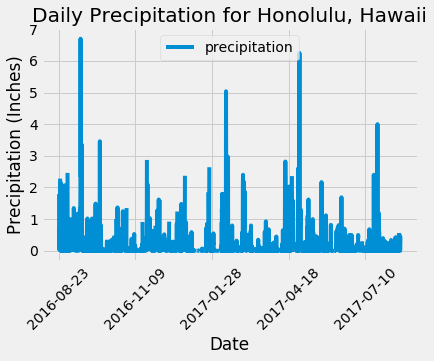

In [72]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df_last_year.plot(rot=45)
ax.set(xlabel="Date",
      ylabel="Precipitation (Inches)",
      title="Daily Precipitation for Honolulu, Hawaii");
plt.savefig("Daily Precipitation.png")

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_last_year.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [77]:
# Print the column names for station
inspector = inspect(engine)
inspector.get_table_names()
cols = inspector.get_columns('station')
for c in cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Design a query to show how many stations are available in this dataset
station_total = (
            Query(Station)
            .with_session(session)
            .count()
)
print(f"There are {station_total} stations in the dataset")

There are 9 stations in the dataset


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busy_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).\
                desc()).\
                all()
print(f"Station {busy_stations[0][0]} has the highest number of observations")
busy_stations

Station USC00519281 has the highest number of observations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
sel = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

active_station = (
                Query(Measurement)
                .filter(Measurement.station == "USC00519281")
                .with_entities(*sel)
                .with_session(session)
                .all()
)
active_station
print(f"The lowest recorded temperature for station {busy_stations[0][0]} is {active_station[0][0]}")
print(f"The highest recorded temperature for station {busy_stations[0][0]} is {active_station[0][1]}")
print(f"The average temperature for station {busy_stations[0][0]} is {active_station[0][2]}")

The lowest recorded temperature for station USC00519281 is 54.0
The highest recorded temperature for station USC00519281 is 85.0
The average temperature for station USC00519281 is 71.66378066378067


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
actv_stn_last_year = (
                    Query(Measurement.date)
                    .filter(Measurement.station == "USC00519281", Measurement.date >= year_ago)
                    .with_entities(Measurement.date, Measurement.tobs)
                    .with_session(session)
                    .all()
)
actv_stn_last_year[:10]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0)]

In [21]:
# Create a dataframe with 12 month query of the most active station
df_asly = pd.DataFrame(actv_stn_last_year, columns=["date", "tobs"])
df_asly.set_index('date', inplace=True)
df_asly

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


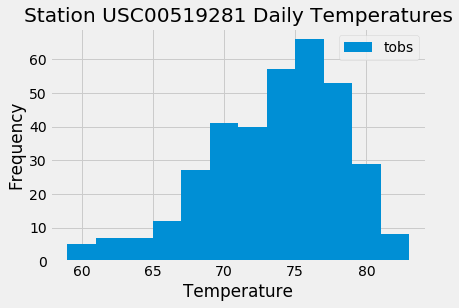

In [22]:
# Plot the results as a histogram
ax2=df_asly.plot(kind="hist", bins=12)
ax2.set(xlabel="Temperature",
       title="Station USC00519281 Daily Temperatures");
plt.savefig("Daily Temperatures.png")

## Bonus Challenge Assignment 

### Temperature Analysis

Planned Vacation Dates: 2017-04-21 to 2017-05-04

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2016-04-21', '2016-05-04')

tmin = trip[0][0]
tavg = trip[0][1]
tmax = trip[0][2]

print(f"The minimum temperature is {tmin}")
print(f"The average temperature is {tavg}")
print(f"The maximum temperature is {tmax}")

The minimum temperature is 68.0
The average temperature is 75.09677419354838
The maximum temperature is 79.0


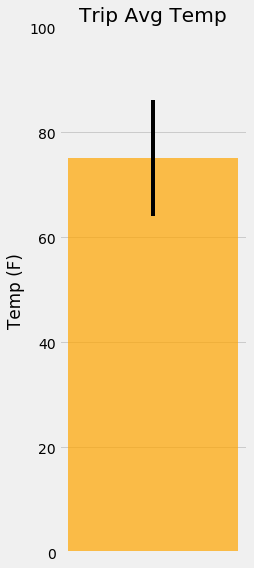

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig3, ax3 = plt.subplots(figsize=(3,9))
ax3.bar(0, tavg, yerr=(tmax-tmin), color="orange", alpha=.7)
ax3.set(title="Trip Avg Temp", xticks=([]), ylabel="Temp (F)")
ax3.set_ylim(0,100);
plt.savefig("Trip Average Temperature.png")

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and 
# list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, 
       Station.name, 
       func.sum(Measurement.prcp), 
       Station.latitude, 
       Station.longitude, 
       Station.elevation]

start_date='2016-04-21'
end_date='2016-05-04'

total_rainfall = (
                Query(Measurement)
                .join(Station, Station.station == Measurement.station)
                .filter(Measurement.date >= start_date)
                .filter(Measurement.date <= end_date)
                .with_session(session)
                .with_entities(*sel)
                .group_by(Measurement.station)
                .order_by((Measurement.prcp).desc())
                .all()
    
)
total_rainfall

# for station in total_rainfall:
#     print(f"Station Name: {total_rainfall[0][0]}")
#     print(f"Station Location: {total_rainfall[0][1]}")
#     print(f"Total Rainfall: {total_rainfall[0][2]}")
#     print(f"Latitude: {total_rainfall[0][3]}")
#     print(f"Longitude: {total_rainfall[0][4]}")
#     print(f"Elevation: {total_rainfall[0][5]}")

df_total_rainfall = pd.DataFrame(total_rainfall, 
                                 columns=["Station Name", "Station Location", "Total Rainfall",
                                         "Latitude", "Longitude", "Elevation"])
df_total_rainfall

,Station Name,Station Location,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.57,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.83,21.52130,-157.83740,7.0
2,USC00513117,"KANEOHE 838.1, HI US",0.63,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.49,21.33556,-157.71139,19.5
4,USC00519397,"WAIKIKI 717.2, HI US",0.11,21.27160,-157.81680,3.0
5,USC00519281,"WAIHEE 837.5, HI US",1.16,21.45167,-157.84889,32.9
6,USC00517948,"PEARL CITY, HI US",0.00,21.39340,-157.97510,11.9


In [27]:
data_check = (
            Query(Measurement)
            .filter(Measurement.date >= "2016-04-21")
            .filter(Measurement.date <= "2016-05-04")
            .filter(Measurement.station == "USC00516128")
            .with_entities(Measurement.station, func.sum(Measurement.prcp))
            .with_session(session)
            .all()
)
data_check

[('USC00516128', 4.57)]

In [52]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching 
# a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), 
           func.avg(Measurement.tobs), 
           func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [64]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2016-04-21"
end_date = "2016-05-04"

# Use the start and end date to create a range of dates
trip_days = []

d = dt.date(2016, 4, 21)

while d <= dt.date(2016, 5,4):
    # Strip off the year and save a list of %m-%d strings
    trip_days.append(dt.datetime.strftime(d, '%m-%d'))
    d += dt.timedelta(days=1)
trip_days

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []

for td in trip_days:
    normals.append(daily_normals(td)[0])
normals

[(66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0),
 (65.0, 73.01818181818182, 79.0),
 (67.0, 73.3103448275862, 80.0),
 (66.0, 73.96551724137932, 83.0),
 (66.0, 74.01724137931035, 81.0),
 (65.0, 72.87272727272727, 81.0),
 (63.0, 73.46428571428571, 79.0),
 (66.0, 73.30357142857143, 81.0),
 (58.0, 71.5576923076923, 78.0),
 (65.0, 72.75925925925925, 79.0),
 (65.0, 73.05084745762711, 79.0),
 (67.0, 73.41071428571429, 84.0),
 (65.0, 73.59649122807018, 78.0)]

In [65]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"], index=trip_days)
df_normals

,tmin,tavg,tmax
04-21,66.0,72.321429,78.0
04-22,65.0,72.927273,84.0
04-23,65.0,73.018182,79.0
04-24,67.0,73.310345,80.0
04-25,66.0,73.965517,83.0
04-26,66.0,74.017241,81.0
04-27,65.0,72.872727,81.0
04-28,63.0,73.464286,79.0
04-29,66.0,73.303571,81.0
04-30,58.0,71.557692,78.0


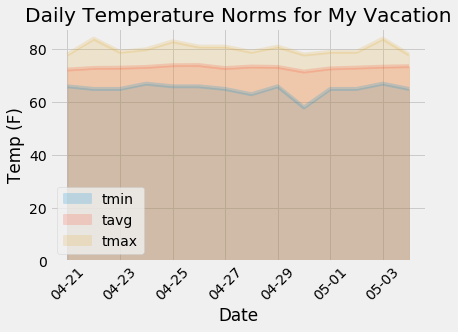

In [73]:
# Plot the daily normals as an area plot with `stacked=False`
ax4 = df_normals.plot.area(stacked=False, alpha=.2, rot=45)
ax4.set(xlabel="Date",
       ylabel="Temp (F)",
        title="Daily Temperature Norms for My Vacation");
